# Abstraction of Objective Function and Some Benchmark Functions

> We define the class `BenchmarkFunction` to represent an objective function. 
> It is a subclass of pytorch `nn.Module`, where `forward` method returns the objective function value.

In [7]:
#| default_exp objectives.benchmark_funs

In [8]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#| export
import torch
import torch.nn as nn
import warnings

class BenchmarkFunction(nn.Module):
    """Some Information about BenchmarkFunction"""

    def __init__(self):
        super().__init__()
        self.name: str = self.__class__.__name__
        self.description: str = self.__class__.__doc__ or "No description"
        # 子类只需要写下面的部分
        self.dimension: int = 0
        self.lb: float = 0  # 简化为一个数
        self.ub: float = 0
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0
        self.larger_better: bool = False
        self._device_test = nn.Parameter(torch.rand(1))  # 用于测试device

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """抽象的适应度函数，子类必须实现这个函数。
        Args:
            x (torch.Tensor): 维度应该为(population_size, self.dimension)
        Returns:
            torch.Tensor: 返回适应度数值, 维度应该为 (population_size)
        """
        warnings.warn("警告：调用了抽象函数。")
        return torch.zeros(x.shape[0])

    def is_input_valid(self, x: torch.Tensor) -> bool:
        """判断输入是否合法。 子类无需实现，而且每次forward不应当调用这个函数，节省时间。
        Args:
            x (torch.Tensor): 维度应该为(population_size, self.dimension)
        Returns:
            bool: 返回是否合法
        """
        return x.shape[1] == self.dimension and bool(torch.all(x >= self.lb)) and bool(torch.all(x <= self.ub))

    def get_device(self) -> torch.device:
        """获取device。 子类无需实现。
            https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
            forward中生成的局部变量，需要指定device。因此需要这样一个测试函数。
        Returns:
            torch.device: 返回device
        """
        return self._device_test.device

    def get_budget(self, alpha: int = 10000) -> int:
        """获取预算。 子类无需实现。
        """
        return self.dimension*alpha


class NegativeProxyObjective(BenchmarkFunction):
    """Convert an maximization problem to a minimization problem, or vice versa. """

    def __init__(self, bf: BenchmarkFunction):
        super().__init__()
        self.bf = bf
        self.name = bf.name
        self.description = bf.description
        self.dimension = bf.dimension
        self.lb = bf.lb 
        self.ub = bf.ub
        self.optinum = bf.optinum
        self.optival = -bf.optival
        self.larger_better = not bf.larger_better

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return -self.bf(x)

Here are some examples of how you can write benchmark functions. 

In [10]:
#| exports
class Sphere(BenchmarkFunction):
    """Sphere Model"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -100  # 简化为一个数
        self.ub: float = 100
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sum(x**2, dim=1)


In [11]:
#| export
class Rosenbrock(BenchmarkFunction):
    """Rosenbrock's Function"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -30  # 简化为一个数
        self.ub: float = 30
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sum(100*(x[:, 1:]-x[:, :-1]**2)**2+(x[:, :-1]-1)**2, dim=1)


class Step(BenchmarkFunction):
    """Step Function"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -100  # 简化为一个数
        self.ub: float = 100
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sum(torch.floor(x+0.5)**2, dim=1)


class NoisyQuartic(BenchmarkFunction):
    """Noisy Quartic"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -1.28  # 简化为一个数
        self.ub: float = 1.28
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return torch.sum(torch.arange(1, x.shape[1]+1).to(x.device)*x**4+torch.rand(1).to(x.device), dim=1)


class Schwefel226(BenchmarkFunction):
    """Schwefel's Problem 2.26"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -500  # 简化为一个数
        self.ub: float = 500
        self.optinum: torch.Tensor = 420.9687*torch.ones(self.dimension)
        self.optival: float = -12569.5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        abs_x = torch.abs(x)
        return -torch.sum(x*torch.sin(torch.sqrt(abs_x)), dim=1)


class Ackley(BenchmarkFunction):
    """Ackley"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -32  # 简化为一个数
        self.ub: float = 32
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return -20 * torch.exp(
            -0.2 * torch.sqrt(torch.sum(x**2, dim=1) / x.shape[1])
        ) - torch.exp(torch.sum(torch.cos(2 * torch.pi * x), dim=1) / x.shape[1]) + 20 + torch.e


class Schwefel222(BenchmarkFunction):
    """Schwefel's Problem 2.22"""

    def __init__(self, dimension: int = 30):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -10  # 简化为一个数
        self.ub: float = 10
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        abs_x = torch.abs(x)
        return torch.sum(abs_x**2, dim=1)+torch.prod(abs_x, dim=1)


class Holder(BenchmarkFunction):
    """Holder Table"""

    def __init__(self, dimension: int = 2):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -10  # 简化为一个数
        self.ub: float = 10
        self.optinum: torch.Tensor = torch.Tensor([8.05502, 9.66459])
        # 还可以有其他解，就是这个解的正负任取。
        self.optival: float = -19.2085

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[:, 0]
        x2 = x[:, 1]
        return -torch.abs(torch.sin(x1)*torch.cos(x2)*torch.exp(torch.abs(1-torch.sqrt(x1**2+x2**2)/torch.pi)))


class Camel3(BenchmarkFunction):
    """Three Hump Camel"""

    def __init__(self, dimension: int = 2):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = -5  # 简化为一个数
        self.ub: float = 5
        self.optinum: torch.Tensor = torch.zeros(self.dimension)
        self.optival: float = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[:, 0]
        x2 = x[:, 1]
        return 2*x1**2 - 1.05*x1**4 + x1**6/6 + x1*x2 + x2**2


class Michal(BenchmarkFunction):
    """Michalewicz"""

    def __init__(self, dimension: int = 2, m:int =10):
        super().__init__()
        self.dimension: int = dimension
        self.lb: float = 0  # 简化为一个数
        self.ub: float = torch.pi
        self.optinum: torch.Tensor = torch.Tensor([2.20, 1.57])
        self.optival: float = -1.8013
        self.m = m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = torch.sin(x) * torch.sin(torch.arange(1,
                                                  x.shape[1]+1).to(x.device)*x**2 / torch.pi)**(2 * self.m)
        return -torch.sum(y, dim=1)


benchmark_functions = [Sphere(), Rosenbrock(), Step(), NoisyQuartic(
), Schwefel226(), Ackley(), Schwefel222(), Holder(), Camel3(), Michal()]

In [14]:
#| hide
import nbdev; nbdev.nbdev_export()

Now we can test the benchmark functions to see how they perform.

In [15]:
from Scientist_Experiment_Optimization.objectives.benchmark_funs import *
s = Sphere()
s.description
s.name
list(s.parameters()) #这是那个测试device的参数

[Parameter containing:
 tensor([0.3631], requires_grad=True)]

You can even compile the function to have a faster speed.

In [16]:
# s = torch.compile(s, mode='reduce-overhead')
# s = s.to('cuda')
# %timeit s.get_device()
# %timeit s._device_test.device
# s = s.to('cpu')

Since here our functions are composed of pytorch derivable functions, we can use gradient based optimization techniques to optimize them.

> Note that we can also define functions that are not derivable. 

In [17]:
x = torch.rand(10, 30, requires_grad=True)
q = s( x )
l = torch.sum(q)
l.backward()
x.grad.shape, x.dtype

(torch.Size([10, 30]), torch.float32)

/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


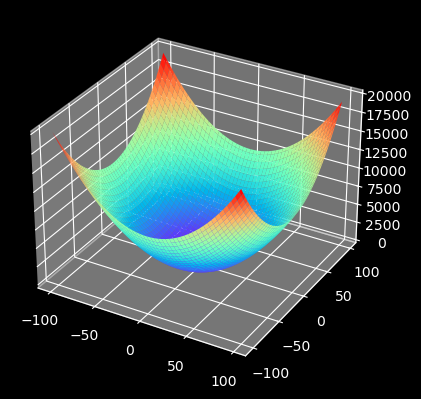

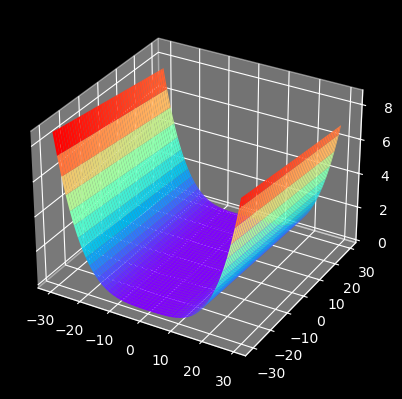

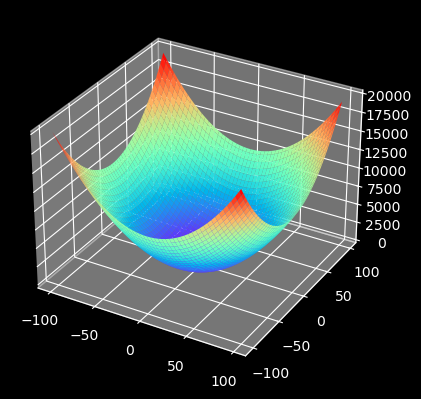

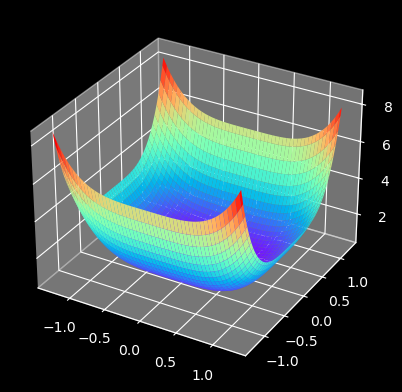

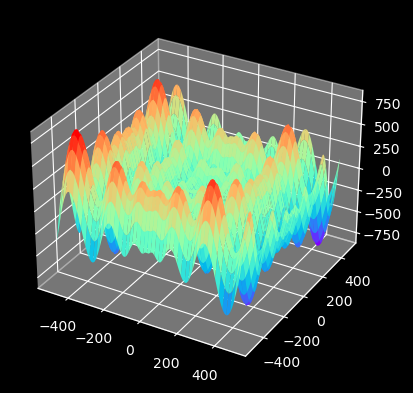

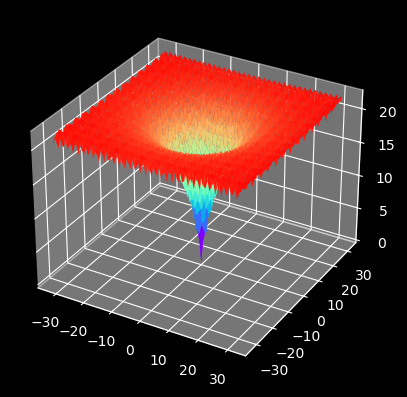

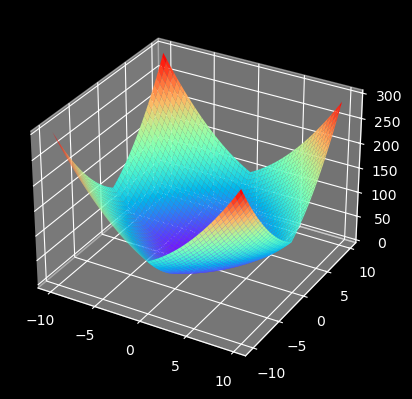

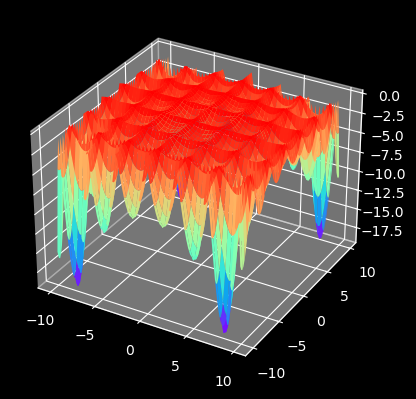

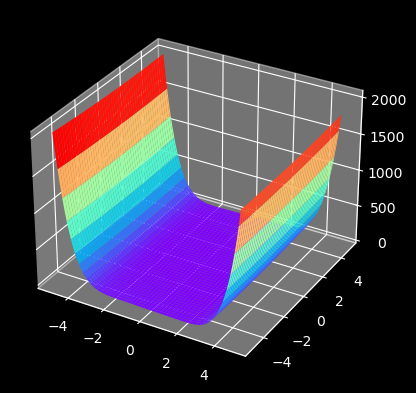

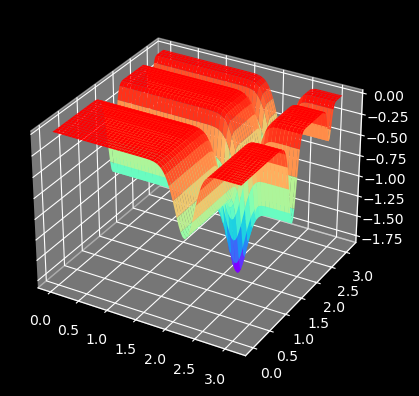

In [18]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Scientist_Experiment_Optimization.utils import runs_figs_path
for fun in benchmark_functions:
    xx = torch.arange(fun.lb, fun.ub, (fun.ub-fun.lb)/100)
    yy = torch.arange(fun.lb, fun.ub, (fun.ub-fun.lb)/100)
    X, Y = torch.meshgrid(xx, yy)
    Z = fun( torch.stack([X, Y], dim=2).reshape(-1, 2) ).reshape(100, 100)
    fig = plt.figure()
    ax3 = fig.add_subplot(111, projection='3d')
    ax3.plot_surface(X, Y, Z, cmap='rainbow')
    plt.savefig(runs_figs_path/f"{fun.name}.png")
    # break

In [19]:
# # 对时间的测试
# device = torch.device("cpu")
# for fun in benchmark_functions:
#     print(fun.get_device())
#     x = torch.rand(1000, 2, requires_grad=True).to(device)
#     fun = fun.to(device)
#     %timeit fun(x)

In [20]:
# # 对时间的测试
# device = torch.device("cpu")
# for fun in benchmark_functions:
#     print(fun.get_device())
#     x = torch.rand(1000, 2, requires_grad=True).to(device)
#     fun = fun.to(device)
#     fun = torch.compile(fun)
#     %timeit fun(x)

In [21]:
# device = torch.device("cuda:0")
# with torch.no_grad(): # 不计算梯度
#     for fun in benchmark_functions:
#         fun = fun.to(device)
#         assert fun.get_device()==device
#         fun.eval() # 不反向传播，但是会计算梯度？
#         # %timeit  fun.to(device) # 8.24 µs ± 56.9 ns
#         x = torch.rand(1000, 30).to(device) # 变大了也差不多快。
#         %timeit fun(x)
#         # fun(x)

In [22]:
# 10000*fun.dimension

In [23]:
#| hide
import nbdev; nbdev.nbdev_export()